# How to train a calibrator

In this notebook we show several ways in which to train a calibrator.

In [1]:
%matplotlib inline
%precision 2
import warnings; warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt

We start by creating a ternary classification problem.

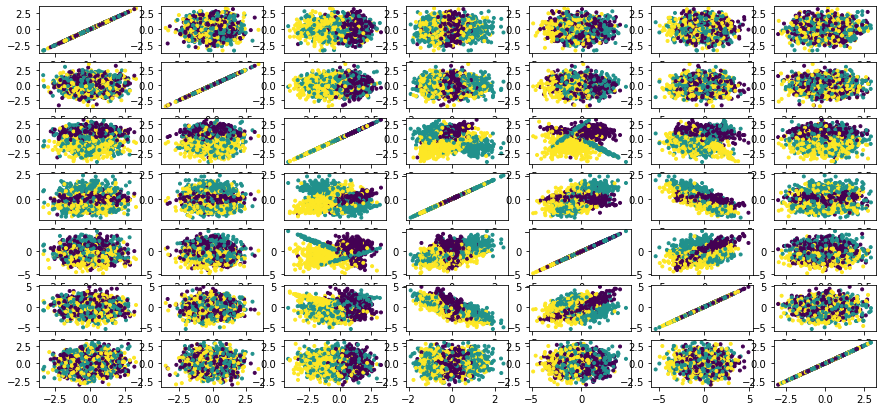

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

n_features = 7
X, y = datasets.make_classification(n_classes=3, n_samples=10000,
                                    n_clusters_per_class=2,
                                    n_features=n_features,
                                    n_informative=int(n_features/2),
                                    n_redundant=int(n_features/4),
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8,
                                                    random_state=42)

fig = plt.figure(figsize=(15, 7))
for i in range(n_features):
    for j in range(n_features):
        ax = fig.add_subplot(n_features, n_features, 1 + i + j*n_features)
        plt.scatter(X_train[:,i], X_train[:,j], c=y_train, marker='.')

## Training the classifier

Here we select which classifier we want to use. We use Gaussian Naive Bayes by default, but feel free to uncoment the import and the instantiation of a different model, or add your own.

In [3]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(C=0.01)

#from sklearn.neighbors import KNeighborsClassifier
#clf = KNeighborsClassifier()

#from sklearn.neural_network.multilayer_perceptron import MLPClassifier
#clf = MLPClassifier()

#from sklearn.svm import SVC
#clf = SVC(kernel='rbf', probability=True)
#clf = SVC(kernel='linear', probability=True)
#clf = SVC(kernel='poly', degree=2, probability=True)
#clf = SVC(kernel='poly', degree=3, probability=True)

We fit the classifier, and obtain the scores for the test set

In [4]:
clf.fit(X_train, y_train)
scores_clf = clf.predict_proba(X_test)

Lets visualis the reliability diagram on the test set

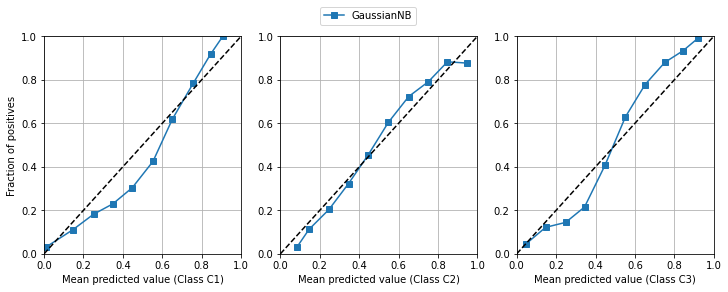

In [5]:
from pycalib.visualisations import plot_reliability_diagram

_ = plot_reliability_diagram(y_test, [scores_clf, ], legend=['GaussianNB', ],
                             histogram=False, class_names=['C1', 'C2', 'C3'])

## Training the calibrator

We will now use a calibrator to adjust the classifier scores

In [6]:
from dirichletcal import FullDirichletCalibrator

cal = FullDirichletCalibrator()

If the calibrator does not have any hyperparameters to be selected, it is possible to train the calibrator ditectly on the same training set used to train the classifier. Otherwise, a new validation set should be used to select the best hyperparameters.

In this example, we will use the same training set. We first obtain the output scores of the classifier in the training set, and then use it to train the calibrator.

In [7]:
scores_clf = clf.predict_proba(X_train)
cal.fit(scores_clf, y_train)

FullDirichletCalibrator()

Once the calibrator has been trained, we can compare the predictinos in the test set. We need the scores of the classifier in the test set to obtain the calibrated scores.

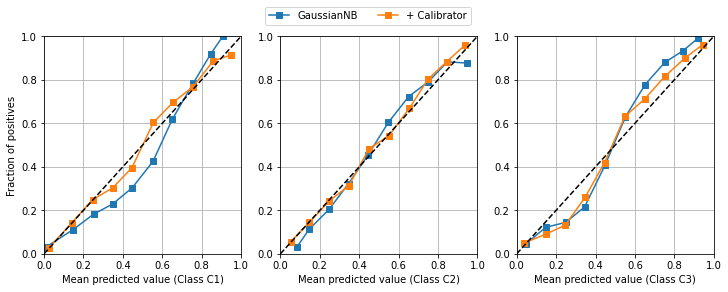

In [8]:
scores_clf = clf.predict_proba(X_test)
scores_cal = cal.predict_proba(scores_clf)

_ = plot_reliability_diagram(y_test, [scores_clf, scores_cal],
                             legend=['GaussianNB', '+ Calibrator'],
                             histogram=False, class_names=['C1', 'C2', 'C3'])

As we can see, some of the classes result in more accurate score predictions. We can check some expected calibration errors as well

In [9]:
from pycalib.metrics import ECE, classwise_ECE, conf_ECE

for metric in ECE, conf_ECE, classwise_ECE:
    print(metric.__name__)
    print('Classifier = {:.3f}'.format(metric(scores_clf, y_test)))
    print('Calibrator = {:.3f}'.format(metric(scores_cal, y_test)))
    print('')

ECE
Classifier = 0.044
Calibrator = 0.021

conf_ECE
Classifier = 0.060
Calibrator = 0.027

classwise_ECE
Classifier = 0.142
Calibrator = 0.074



Another widely used method to calibrate a classifier is to train $K$ calibrators on different partitions of the training set, and average their predictions (also helpping to regularise the calibrator).

# Training a calibrated classifier

The previous steps can be automated using implementations that already exist in Python libraries, here we show some examples:

## Scikit-learn CalibratedClassifierCV (sigmoid and isotonic)

The Scikit learn library has a method to train Isotonic Regression or Platt's scaling using cross-validation. The method trains several calibrators (one per cross-validation partition) and generates predictions according to the averaged scores.

It works as well with multiclass classification by binarizing the problem in a one vs rest manner and trains one calibrator per class. The output of all calibrators are normalised to sum to one.

It is possible to use a pretrained classifier, or train it together with the calibrator

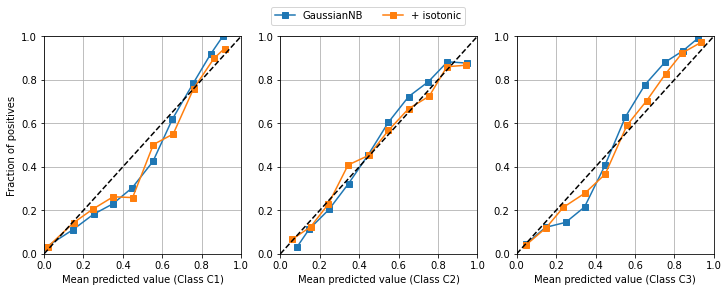

In [10]:
from sklearn.calibration import CalibratedClassifierCV

calibrator_name = 'isotonic' # try with 'sigmoid'

cal = CalibratedClassifierCV(clf, cv=2, method='isotonic')

cal.fit(X_train, y_train)
scores_cal = cal.predict_proba(X_test)

_ = plot_reliability_diagram(y_test, [scores_clf, scores_cal],
                             legend=['GaussianNB', '+ {}'.format(calibrator_name)],
                             histogram=False, class_names=['C1', 'C2', 'C3'])

In [11]:
from pycalib.metrics import ECE, classwise_ECE, conf_ECE

for metric in ECE, conf_ECE, classwise_ECE:
    print(metric.__name__)
    print('Classifier = {:.3f}'.format(metric(scores_clf, y_test)))
    print('Calibrator = {:.3f}'.format(metric(scores_cal, y_test)))
    print('')

ECE
Classifier = 0.044
Calibrator = 0.019

conf_ECE
Classifier = 0.060
Calibrator = 0.033

classwise_ECE
Classifier = 0.142
Calibrator = 0.084



## PyCalib CalibratedClassifierCV (arbitrary calibrator)

We are currently working on the PyCalib library to adapt the code from Scikit-learn in order to accept any calibrator that follows the ScikitLearn conventions for a probabilistic classifier.

# PyCalib CalibratedModel (arbitrary calibrator)

You can also use the CalibratedModel class that wraps together a classifier and any calibrator. For binary or multiclass. In this case the calibrator is assumed to be multiclass (also acceps binary problems).

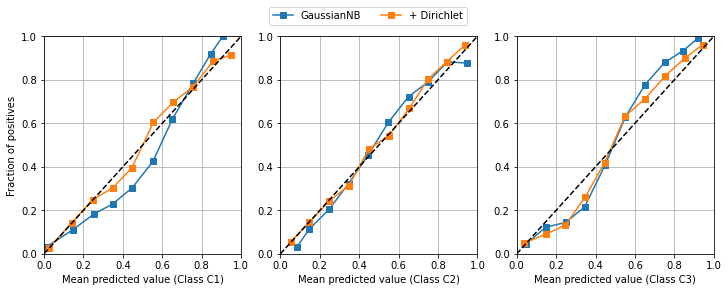

In [12]:
from pycalib.models import CalibratedModel
from dirichletcal import FullDirichletCalibrator

cal = CalibratedModel(clf, method=FullDirichletCalibrator())

cal.fit(X_train, y_train)

scores_clf = cal.base_estimator.predict_proba(X_test)
scores_cal = cal.predict_proba(X_test)
_ = plot_reliability_diagram(y_test, [scores_clf, scores_cal], legend=['GaussianNB', '+ Dirichlet'],
                             histogram=False, class_names=['C1', 'C2', 'C3'])

# Multiclass

The previous CalibratedModel also works for multiclass problems. However, if we want to use a binary calibrator we provide an additional class that uses the one vs the rest approach to train several binary calibrators.

In the following example we use the binary width binning calibrator with using one vs the rest.

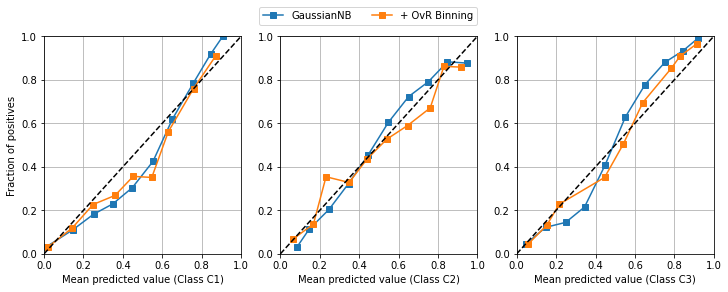

In [13]:
from pycalib.models import OneVsRestCalibrator, BinningCalibration

cal = CalibratedModel(GaussianNB(), method=OneVsRestCalibrator(BinningCalibration()))
cal.fit(X_train, y_train)

scores_clf = cal.base_estimator.predict_proba(X_test)
scores_cal = cal.predict_proba(X_test)

_ = plot_reliability_diagram(y_test, [scores_clf, scores_cal], legend=['GaussianNB', '+ OvR Binning'],
                             histogram=False, class_names=['C1', 'C2', 'C3'])